In [2]:
import os
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Anaconda3\envs\py36_32\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Replication assignment

Replicate the results found in [Bryant et al  (2010)](https://doi.org/10.1016/j.techfore.2009.08.002), [Rozenberg et al (2014)](https://link.springer.com/content/pdf/10.1007/s10584-013-0904-3.pdf), and [Hamarat et al (2013)](https://doi.org/10.1016/j.techfore.2012.10.004). The data files are named accordingly. The full details for these papers can be found the course guide. Rozenberg et al and Hamarat et al are optional readings for this week. You can also look at [Kwakkel & Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092), which gives a succint summary of these three cases. 

An additional useful, if dated, resource for Bryant et al is https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/ 

mpld3 is no longer supported for python 3.6. Instead, use the `%matplotlib notebook` [magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib) for interaction with the trade-off curves. You can revert back to inline with `%matplotlib inline`


# Bryant & Lempert

*hint load the data using pandas, extract the experiments and outcomes from it. Cast the experiments to a numpy recarray*

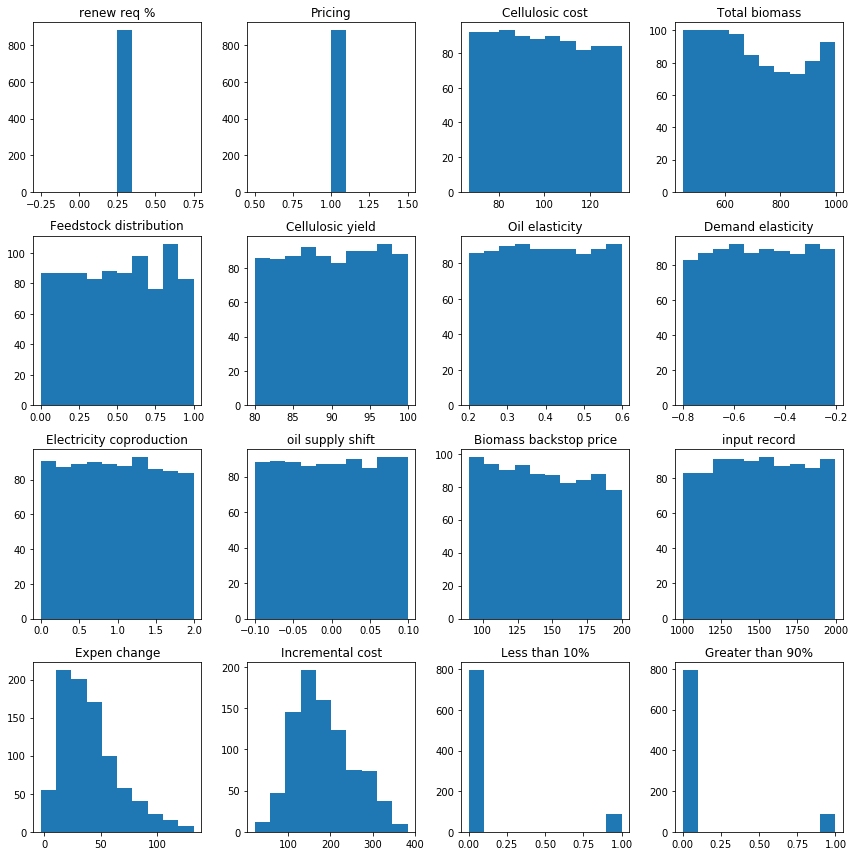

In [2]:
# Check how data consists of:
df = pd.read_csv("./data/Bryant et al 2010.csv")
# print(df.head())
plt.figure(figsize = (12,12))
i = 0
for col in df.columns:
    i += 1
    plt.subplot(4, 4, i)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout()

In [3]:
params = df.columns[2:11]
params

Index(['Cellulosic cost', 'Total biomass', 'Feedstock distribution',
       'Cellulosic yield', 'Oil elasticity', 'Demand elasticity',
       'Electricity coproduction', 'oil supply shift',
       'Biomass backstop price'],
      dtype='object')

Text(0.5,1,'Distribution of Outcomes \n(10% Boundary at "Expen change" = 77.98)')

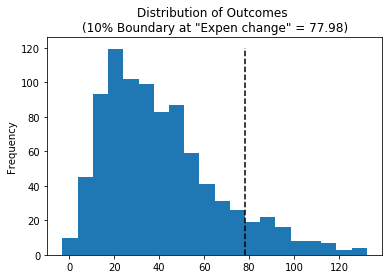

In [4]:
# what is the boundary between "desirable" and "undesirable"
fig, ax = plt.subplots()
q = df["Expen change"].quantile(q=0.90)
q = np.round(q,2)
df["Expen change"].plot(kind="hist", ax = ax, bins = 20)
ax.vlines(x=q,ymin=0,ymax=120,linestyle="--")
ax.set_title('Distribution of Outcomes \n(10% Boundary at "Expen change" = {q})'.format(q=q))

In [5]:
print(df[df["Expen change"] > q]["Greater than 90%"].unique())
print(df[df["Expen change"] >= q]["Less than 10%"].unique())
# all rows are labeld in correct way!

[1]
[0]


### Depending on parameters, See how Desirable and Undesirable Outcomes are generated

In [6]:
units = ["$ per unit input", "millions of tons", "pessimistic to optimistic", "gallons per ton", "", "", "kWh per gallon", "% change", "$ per ton"]

Text(0.5,0,'0: Desirable, 1: Undesirable')

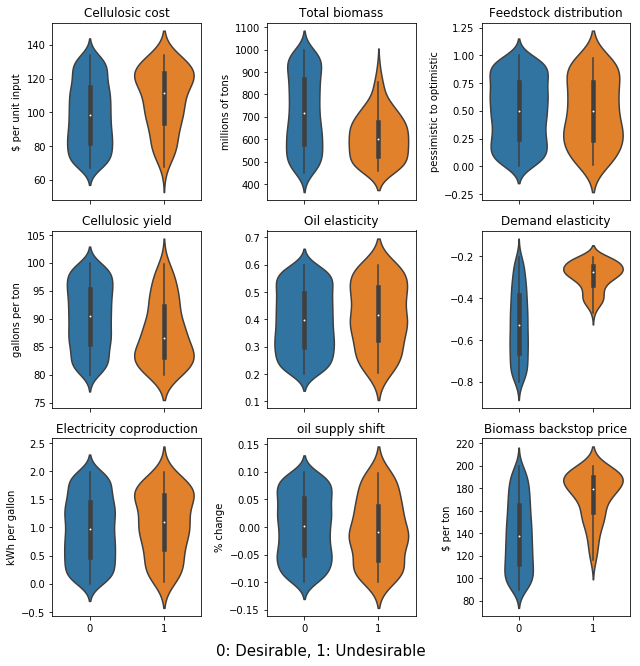

In [7]:
ncols=3
nrows=3
fig, axes = plt.subplots(ncols = ncols, nrows = nrows,
                         sharex = True,
                         figsize = (9,9))
locs = list(itertools.product(range(nrows),range(ncols)))

for i,param in enumerate(params):
    loc=locs[i]
    ax=axes[loc]
    sns.violinplot("Greater than 90%", param, data = df, ax=ax, legend=True)
    ax.set_xlabel("")
    ax.set_ylabel(units[i])
    ax.set_title(param)
fig.tight_layout()
fig.suptitle("Differences (from Input Parameters) which make Outcome Different", y=1.02, fontsize = 15)
fig.suptitle("0: Desirable, 1: Undesirable", y=0.00, fontsize = 15)

### Interpretation:
    what makes different outcome? (0:Desirable or 1: Undesirable)
    → Estimated Importance Rank (Visually)
    1. 'Demand elasticity'
    2. 'Biomass backstop price'
    3. 'Total biomass'
    4. 'Cellulosic cost'
    
    Other inputs: Doesn't seem to be so important

Some Clusters are observed!


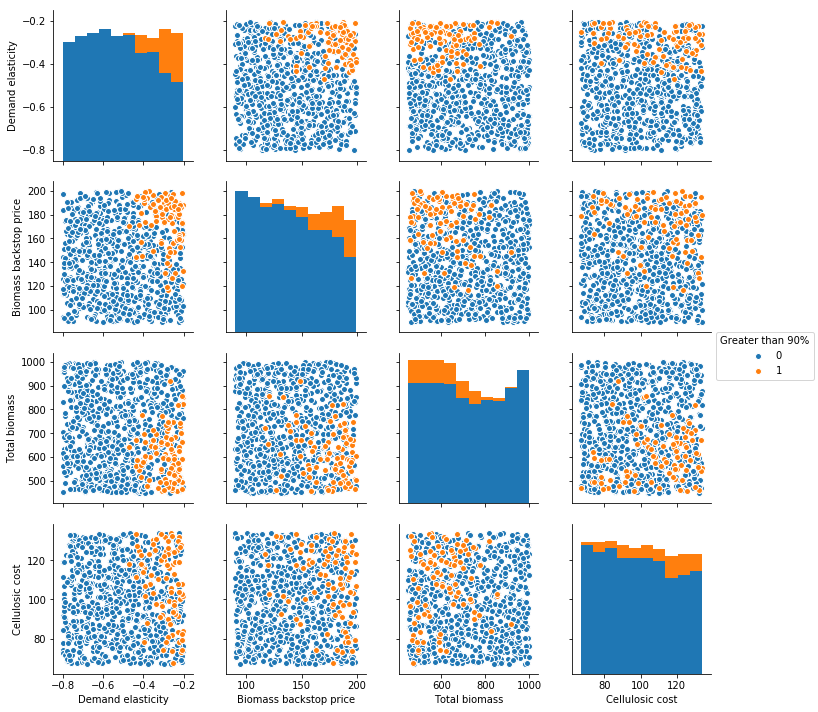

In [8]:
import_params = ['Demand elasticity', 'Biomass backstop price', 'Total biomass', 'Cellulosic cost']
sns.pairplot(df, hue="Greater than 90%", vars = import_params)
print("Some Clusters are observed!")

### Find out these clusters by PRIM

In [22]:
from ema_workbench.analysis import prim
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [10]:
x = df[params].to_records()
y = df["Greater than 90%"].values

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] 882 points remaining, containing 89 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05102040816326531, coverage: 0.5056179775280899, density: 1.0 restricted_dimensions: 6


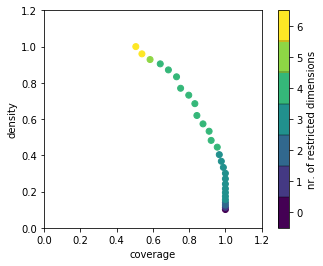

In [11]:
box1.show_tradeoff()
plt.show()

In [12]:
box1.inspect(i = 20, style='table')

coverage    0.797753
density     0.731959
mass        0.109977
mean        0.731959
res dim            4
Name: 20, dtype: object

                            box 20                                      
                               min         max                 qp values
Demand elasticity        -0.422000   -0.202000   [7.079941163959903e-19]
Biomass backstop price  138.599998  199.600006   [5.228199370673111e-10]
Total biomass           450.000000  755.799988  [1.0998160915512434e-06]
Cellulosic cost          72.650002  133.699997     [0.10301317448152089]



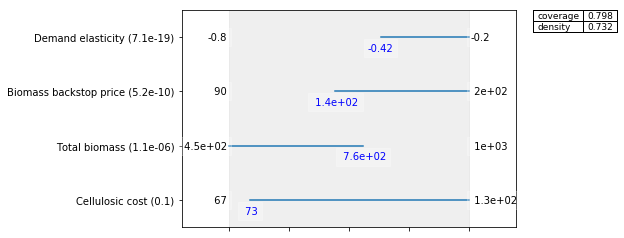

In [13]:
box1.inspect(i = 20, style='graph')
plt.show()

# Rozenberg et al

there are several issues with this case
* apply prim separately for each SSP
* you have to play with the threshold for each SSP, the default of 0.8 is too high in several cases
* if you look at the paper carefully, you will discover that they change some of the default parameters of PRIM


In [14]:
df = pd.read_csv("./data/Rozenberg et al 2014.csv")
df.head()

,inequalities,convergence,population,behaviors,technologies,fossils,capital markets,SSP1,SSP2,SSP3,SSP4,SSP5
0,0,2,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,1,0,0,0,0,0
2,0,2,0,0,0,1,0,0,0,0,0,0
3,0,2,0,0,0,1,1,0,0,0,0,0
4,0,2,0,0,1,0,0,0,1,0,0,0


In [15]:
SSPs = df.columns[-5:]
params = df.columns[:7]

In [16]:
SSPs

Index(['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5'], dtype='object')

In [17]:
params

Index(['inequalities', 'convergence', 'population', 'behaviors',
       'technologies', 'fossils', 'capital markets'],
      dtype='object')

### Implement <code>threshold = 0.8</code> to all SSPs

In [18]:
x = df[params].to_records()

boxes = []
for i, SSP in enumerate(SSPs):
    y = df[SSPs[i]].values
    prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
    box = prim_alg.find_box()
    boxes.append(box)

[MainProcess/INFO] 286 points remaining, containing 44 cases of interest
[MainProcess/INFO] mean: 0.9375, mass: 0.055944055944055944, coverage: 0.3409090909090909, density: 0.9375 restricted_dimensions: 4
[MainProcess/INFO] 286 points remaining, containing 28 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.55, returning dump box
[MainProcess/INFO] 286 points remaining, containing 40 cases of interest
[MainProcess/INFO] mean: 0.9166666666666666, mass: 0.08391608391608392, coverage: 0.55, density: 0.9166666666666666 restricted_dimensions: 4
[MainProcess/INFO] 286 points remaining, containing 23 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.055944055944055944, coverage: 0.6956521739130435, density: 1.0 restricted_dimensions: 4
[MainProcess/INFO] 286 points remaining, containing 19 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.4583333333333333, returning dump box


[MainProcess/INFO] 286 points remaining, containing 44 cases of interest
[MainProcess/INFO] mean: 0.9375, mass: 0.055944055944055944, coverage: 0.3409090909090909, density: 0.9375 restricted_dimensions: 4


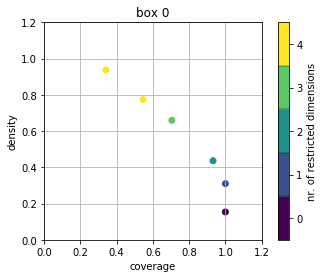

[MainProcess/INFO] 286 points remaining, containing 28 cases of interest
[MainProcess/INFO] mean: 0.55, mass: 0.06993006993006994, coverage: 0.39285714285714285, density: 0.55 restricted_dimensions: 4


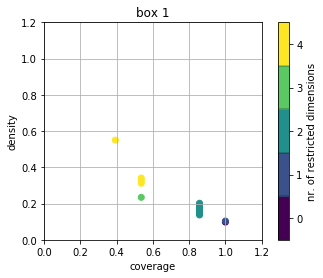

[MainProcess/INFO] 286 points remaining, containing 40 cases of interest
[MainProcess/INFO] mean: 0.9166666666666666, mass: 0.08391608391608392, coverage: 0.55, density: 0.9166666666666666 restricted_dimensions: 4


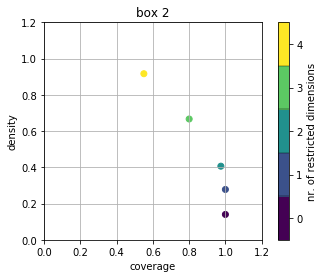

[MainProcess/INFO] 286 points remaining, containing 23 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.055944055944055944, coverage: 0.6956521739130435, density: 1.0 restricted_dimensions: 4


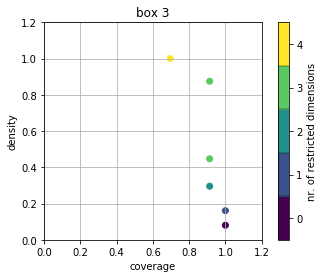

[MainProcess/INFO] 286 points remaining, containing 19 cases of interest
[MainProcess/INFO] mean: 0.4583333333333333, mass: 0.08391608391608392, coverage: 0.5789473684210527, density: 0.4583333333333333 restricted_dimensions: 3


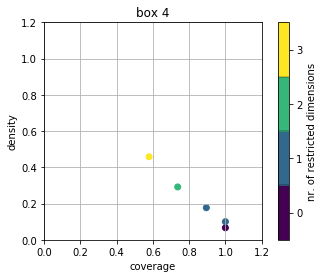

In [19]:
# 2nd and 5th boxes does not meet threshold criteria
thresholds = [0.8, 0.55, 0.8, 0.8, 0.458]

# re-run the code
x = df[params].to_records()
boxes = []

for i, SSP in enumerate(SSPs):
    y = df[SSPs[i]].values
    prim_alg = prim.Prim(x, y, threshold=thresholds[i], peel_alpha=0.05)
    # find box
    box = prim_alg.find_box()
    boxes.append(box)
    # plot box
    box.show_tradeoff()
    plt.grid()
    plt.title("box %s"%i)
    plt.show()

In [20]:
def inspect_box(boxes, SSP_num, box_num):
    box = boxes[SSP_num]
    box.inspect(i = box_num, style='table')
    box.inspect(i = box_num, style='graph')
    plt.show()

### SSP1

coverage    0.704545
density     0.659574
mass        0.164336
mean        0.659574
res dim            3
Name: 3, dtype: object

             box 3                              
               min  max                qp values
behaviors      1.0  1.0  [1.469768735781625e-06]
inequalities   1.0  1.0   [0.000977219127931685]
population     0.0  1.0   [0.005972420192480504]



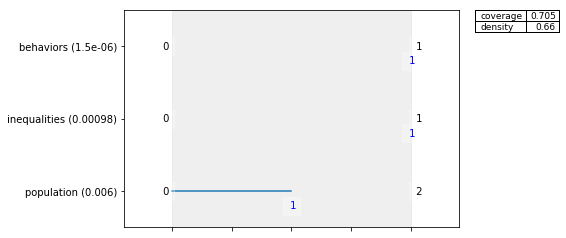

In [21]:
#inspect the 4th box of SSP1
inspect_box(boxes, 0, 3)

    behavior: high
    inequalities: improved
    population: medium or low

coverage    0.545455
density     0.774194
mass        0.108392
mean        0.774194
res dim            4
Name: 4, dtype: object

             box 4                               
               min  max                 qp values
behaviors      1.0  1.0  [3.4031943088371027e-06]
inequalities   1.0  1.0    [0.003785542610549001]
population     0.0  1.0    [0.008398575356226201]
convergence    1.0  2.0     [0.07219042578677633]



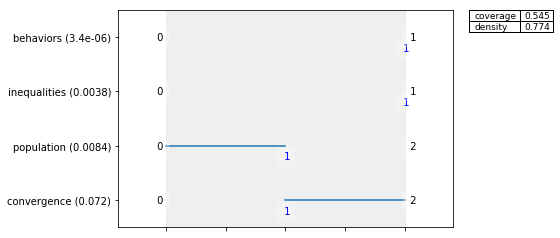

In [22]:
#inspect the 5th box of SSP1
inspect_box(boxes, 0, 4)

    behavior: high
    inequalities: improved
    population: medium or low
    convergence: medium and fast

### SSP2

coverage     0.392857
density          0.55
mass        0.0699301
mean             0.55
res dim             4
Name: 15, dtype: object

            box 15                                                  
               min    max                                  qp values
population     0.0    0.0                     [0.003942141664083466]
behaviors      0.0    0.0                     [0.003942141664083466]
index        100.0  262.0  [0.04686775743989334, 0.5913611846716273]
convergence    0.0    1.0                      [0.11407210047466887]



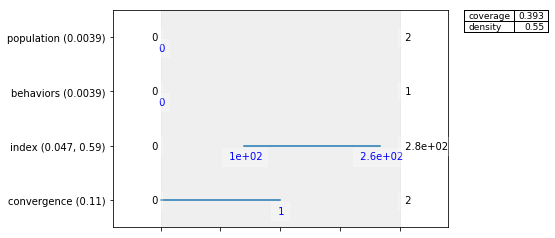

In [23]:
#inspect the 16th box of SSP2
inspect_box(boxes, 1, 15)

    population: Low
    behavior: Low (energy sobriety?)
    index: (?) -> this shouldn't be considered
    convergence: medium or slow

### SSP3

coverage         0.8
density     0.666667
mass        0.167832
mean        0.666667
res dim            3
Name: 3, dtype: object

             box 3                               
               min  max                 qp values
behaviors      0.0  0.0   [3.130396509639097e-06]
inequalities   0.0  0.0  [0.00023925686322256464]
population     1.0  2.0    [0.002914918307607955]



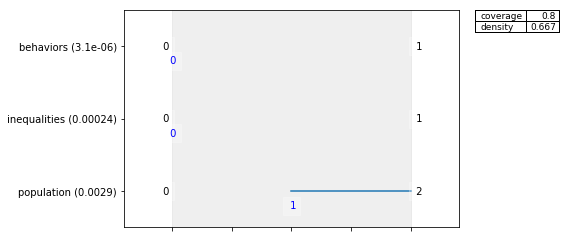

In [24]:
#inspect the 4th box of SSP3
inspect_box(boxes, 2, 3)

    behavior: Low
    inequality: worsen
    population: high or medium

coverage         0.55
density      0.916667
mass        0.0839161
mean         0.916667
res dim             4
Name: 4, dtype: object

             box 4                              
               min  max                qp values
behaviors      0.0  0.0  [4.708610254878667e-06]
inequalities   0.0  0.0  [0.0007563634621240565]
population     1.0  2.0  [0.0021975761425310184]
technologies   0.0  0.0   [0.004871061749211022]



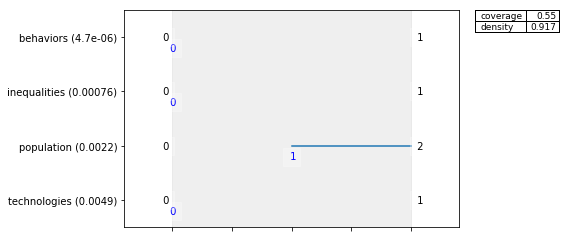

In [25]:
#inspect the 5th box of SSP3
inspect_box(boxes, 2, 4)

    behavior: Low
    inequality: worsen
    population: high or medium
    technology: low

### SSP4

coverage     0.913043
density         0.875
mass        0.0839161
mean            0.875
res dim             3
Name: 4, dtype: object

             box 4                               
               min  max                 qp values
convergence    0.0  0.0  [5.8154822275538926e-09]
inequalities   0.0  0.0  [1.1582287777091569e-05]
behaviors      1.0  1.0   [6.336598320679067e-05]



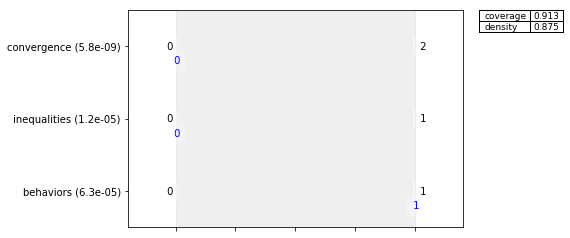

In [26]:
#inspect the 5th box of SSP4
inspect_box(boxes, 3, 4)

    convergence: low
    inequality: worsen
    behavior: high

coverage     0.695652
density             1
mass        0.0559441
mean                1
res dim             4
Name: 5, dtype: object

             box 5                               
               min  max                 qp values
convergence    0.0  0.0  [3.2535238562949594e-08]
inequalities   0.0  0.0       [1.52587890625e-05]
behaviors      1.0  1.0  [0.00010045242572063329]
population     0.0  1.0      [0.1180670870212488]



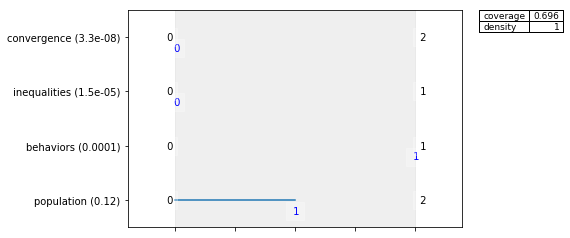

In [27]:
#inspect the 6th box of SSP4
inspect_box(boxes, 3, 5)

    convergence: low
    inequality: worsen
    behavior: high
    population: medium or low

### SSP5

coverage     0.578947
density      0.458333
mass        0.0839161
mean         0.458333
res dim             3
Name: 4, dtype: object

             box 4                             
               min  max               qp values
convergence    2.0  2.0  [0.001616972965573594]
inequalities   1.0  1.0  [0.011131987844474327]
behaviors      0.0  0.0   [0.06193796026800955]



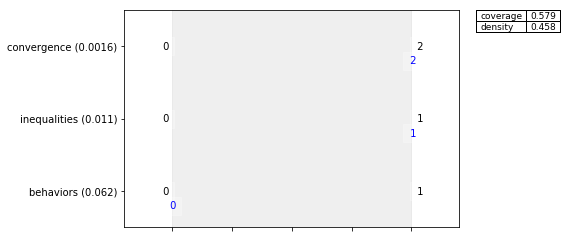

In [28]:
#inspect the 6th box of SSP5
inspect_box(boxes, 4, 4)

    convergence: fast
    inequality: improved
    behavior: low

# Hamarat et al

this is the most difficult dataset to analyze with prim. As can be seen by the results, PRIM fails to find a good explanation for why negative outcomes occur. 


In [3]:
from ema_workbench import load_results

results = load_results("./data/Hamarat et al 2013.gz")

def result_df(results):
    df = pd.DataFrame()
    for i, key in enumerate(results[1].keys()):
        df[key] = results[1][key].flatten()

    n_experiment = np.arange(results[1][key].shape[0])
    n_steps = results[1][key].shape[1]

    df["replication"] = np.repeat(n_experiment, n_steps)
    return df

def result_input(results):
    df_input = pd.DataFrame(index=list(results[0].dtype.names)[:5])
    for i in range(len(results[0])):
        df_input[i] = list(results[0][i])[:5]
    return df_input.T

df_outcome = result_df(results)
df_input = result_input(results)

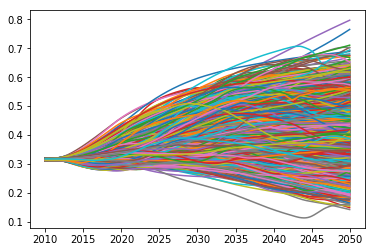

In [10]:
for i in range(5000):
    df = df_outcome[df_outcome["replication"] == i]
    plt.plot(df["TIME"], df["fraction renewables"])

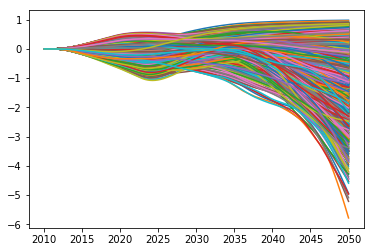

In [12]:
for i in range(5000):
    df = df_outcome[df_outcome["replication"] == i]
    plt.plot(df["TIME"], df["carbon emissions reduction fraction"])

### Set the outcome of the interest as: Final Value (at <code>TIME</code> = 2050)

In [37]:
x = df_input.astype(str).to_records()
ys = df_outcome[df_outcome["TIME"] == 2050][["fraction renewables","carbon emissions reduction fraction"]].values

y = ys[:,0]
prim_alg = prim.Prim(x, y, threshold=0.448, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 1229 cases of interest
[MainProcess/INFO] mean: 0.44814931914724154, mass: 0.058, coverage: 0.11798209926769732, density: 0.5 restricted_dimensions: 4


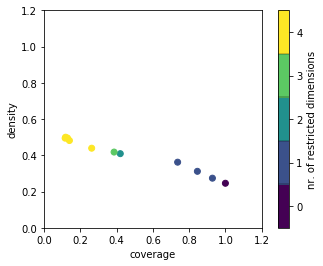

In [38]:
box1.show_tradeoff()
plt.show()

coverage    0.736371
density     0.362145
mass          0.4998
mean        0.423847
res dim            1
Name: 3, dtype: object

                            box 3                                 
                              min        max             qp values
SWITCH economic growth  {6, 3, 4}  {6, 3, 4}  [0.9996714657376988]



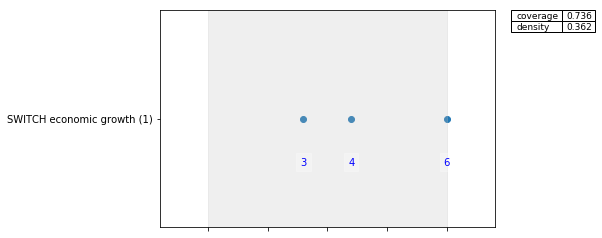

In [41]:
box1.inspect(i = 3, style='table')
box1.inspect(i = 3, style='graph')
plt.show()

coverage    0.419854
density     0.409199
mass          0.2522
mean        0.431914
res dim            2
Name: 4, dtype: object

                                       box 4                                  
                                         min        max              qp values
SWITCH economic growth             {6, 3, 4}  {6, 3, 4}  [0.26419875027467876]
SWITCH Market price determination        {1}        {1}   [0.8602320922829001]



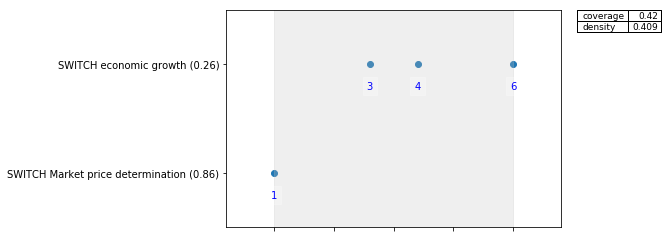

In [42]:
box1.inspect(i = 4, style='table')
box1.inspect(i = 4, style='graph')
plt.show()

    → qp-value is too high!

coverage    0.385679
density     0.417989
mass          0.2268
mean        0.433484
res dim            3
Name: 5, dtype: object

                                       box 5                                  
                                         min        max              qp values
SWITCH economic growth             {6, 3, 4}  {6, 3, 4}  [0.11759975412418057]
SWITCH Market price determination        {1}        {1}   [0.6832567012305868]
index                                      0       4495   [0.8356095104116341]



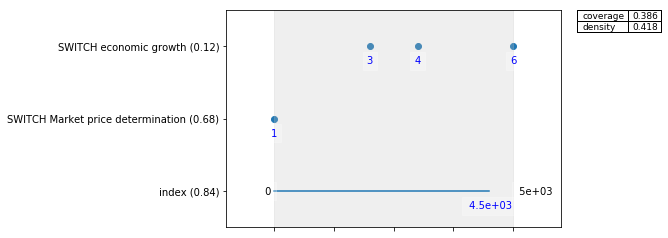

In [46]:
box1.inspect(i = 5, style='table')
box1.inspect(i = 5, style='graph')
plt.show()